In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
DATA_PATH = "Online Retail.xlsx"
df = pd.read_excel(DATA_PATH)
print("Initial rows and columns:", df.shape[0]) 

Initial rows and columns: 541909


In [3]:
df = df[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce') 
df = df.dropna(subset=['CustomerID']) 

df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] >= 0] 

df['CustomerID'] = df['CustomerID'].astype(int).astype(str) 
print("Rows and columns after cleaning:", df.shape[0]) 

Rows and columns after cleaning: 397924


In [4]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice'] 

In [5]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot date:", snapshot_date.date())

Snapshot date: 2011-12-10


In [7]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, 'InvoiceNo': 'nunique', 'TotalPrice': 'sum'}).reset_index()
rfm.rename(columns = {'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalPrice':'Monetary'}, inplace=True)
print(rfm[['Recency', 'Frequency', 'Monetary']].describe().round(2)) 

       Recency  Frequency   Monetary
count  4339.00    4339.00    4339.00
mean     92.52       4.27    2053.79
std     100.01       7.71    8988.25
min       1.00       1.00       0.00
25%      18.00       1.00     307.24
50%      51.00       2.00     674.45
75%     142.00       5.00    1661.64
max     374.00     210.00  280206.02


In [10]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int) 
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Score'] =rfm['R_Score'].map(str) + rfm['F_Score'].map(str) + rfm['M_Score'].map(str)
rfm['RFM_Sum'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score'] 

In [11]:
def segment_customer(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Best Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 2 and row['F_Score'] >= 4:
        return 'Frequent but not recent Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
        return 'Recent but not frequent Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] >= 1:
        return 'New Customers'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'Inactive Customers'
    else:
        return 'At Risk'
    
rfm['Segment'] = rfm.apply(segment_customer, axis=1)
print(rfm['Segment'].value_counts()) 

Segment
Inactive Customers                   1065
Loyal Customers                       998
Best Customers                        962
At Risk                               778
Recent but not frequent Customers     320
Frequent but not recent Customers     216
Name: count, dtype: int64


In [14]:
segment_summary = rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Sum': 'mean'
}).rename(columns={'CustomerID': 'Count'}).sort_values(by='Count', ascending=False)
print(segment_summary.round(1)) 

                                   Count  Recency  Frequency  Monetary  \
Segment                                                                  
Inactive Customers                  1065    217.9        1.1     487.7   
Loyal Customers                      998     34.1        3.7    1477.1   
Best Customers                       962     12.9       11.1    6038.8   
At Risk                              778    119.7        2.0     771.6   
Recent but not frequent Customers    320     18.5        1.2     456.8   
Frequent but not recent Customers    216    110.7        4.9    1676.4   

                                   RFM_Sum  
Segment                                     
Inactive Customers                     4.7  
Loyal Customers                       10.6  
Best Customers                        13.9  
At Risk                                7.1  
Recent but not frequent Customers      7.8  
Frequent but not recent Customers     10.0  


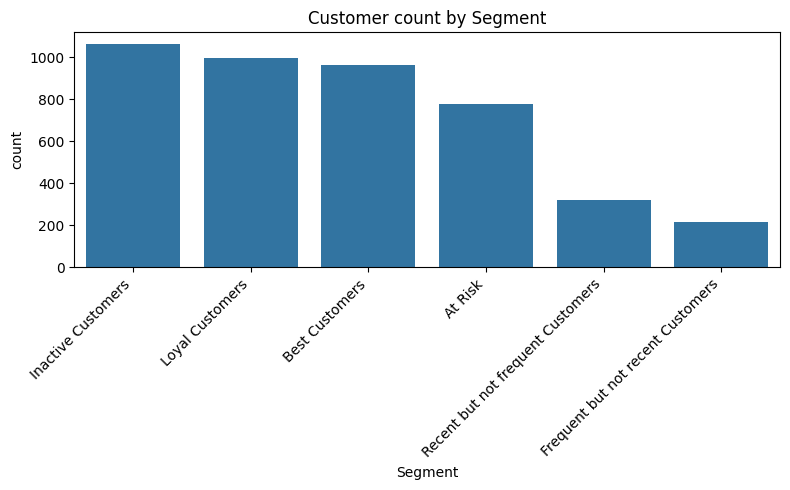

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=segment_summary.index)
plt.xticks(rotation=45, ha='right')
plt.title('Customer count by Segment')
plt.tight_layout()
plt.show() 

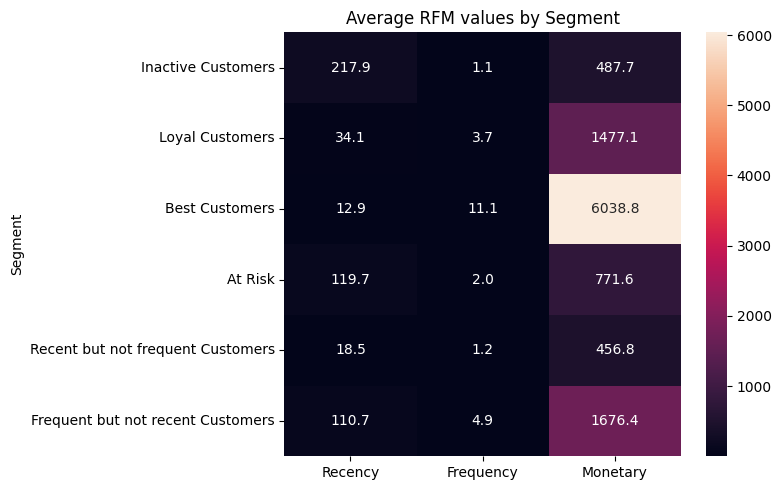

In [16]:
seg_stats = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().loc[segment_summary.index]
plt.figure(figsize=(8,5))
sns.heatmap(seg_stats, annot=True, fmt=".1f")
plt.title('Average RFM values by Segment')
plt.tight_layout()
plt.show()

In [2]:
#filename = "rfm_by_customer.csv"
# save the RFM summary (use the rfm dataframe that contains the aggregated customer metrics)
#rfm.to_csv(filename, index=False)
#print(f"Saved to: {filename}")